In [6]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

In [7]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [2]:
fashion_mnist_train = FashionMNIST(
    'data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
fashion_mnist_test = FashionMNIST(
    'data/FashionMNIST',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 26421880/26421880 [01:34<00:00, 279084.75it/s]


Extracting data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 96369.48it/s]


Extracting data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:19<00:00, 227313.10it/s]


Extracting data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7515585.45it/s]

Extracting data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



In [8]:
batch_size = 128
train_loader = DataLoader(
    fashion_mnist_train,
    batch_size = batch_size,
    shuffle=True
)
test_loader = DataLoader(
    fashion_mnist_test,
    batch_size = batch_size,
    shuffle=False
)

In [9]:
xx = next(iter(train_loader))

In [12]:
# (N, C, H, W)
xx[0].shape

torch.Size([128, 1, 28, 28])

In [13]:
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

# Conv2d(input channel, output channel, kernel size)
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),    # size = size - 5 + 1 = 28 - 5 + 1 = 24 => (128, 32, 24, 24)
    nn.MaxPool2d(2),        # size / 2 => (128, 32, 12, 12)
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(.25),
    nn.Conv2d(32, 64, 5),   # size = 12 - 4 = 8 => (128, 64, 8, 8)
    nn.MaxPool2d(2),        # size / 2 => (128, 64, 4, 4)
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout(.25),
    FlattenLayer()          # C * W * H => (128, 64 * 4 * 4) => (128, 256 * 4) => (128, 1024)
)

In [14]:
test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]
print(conv_output_size)

1024


In [18]:
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(.25),
    nn.Linear(200, 10)
)
net = nn.Sequential(
    conv_net,
    mlp
)

In [28]:
def eval_net(net, data_loader, device='cpu'):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x, y = (d.to(device) for d in [x, y])
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
        
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [30]:
import pandas as pd

def train_net(
    net,
    train_loader, test_loader,
    optimizer_cls = optim.Adam,
    loss_fn = nn.CrossEntropyLoss(),
    n_iter = 10,
    device = 'cpu'
):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    
    df_history = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'val_acc'])
    for epoch in range(n_iter):
        running_loss, n, n_acc = 0.0, 0, 0
        net.train()
        
        for i, data in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            
            xx, yy = (d.to(device) for d in data)
            result = net(xx)
            loss = loss_fn(result, yy)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = result.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n)
        
        val_acc.append(eval_net(net, test_loader, device))
        df_history.loc[len(df_history)] = [epoch, train_losses[epoch], train_acc[epoch], val_acc[epoch]]
        
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
        
    return df_history
        
            

In [31]:
device = torch.device('cuda:0')

net.to(device)
df_history = train_net(net, train_loader, test_loader, n_iter=20, device=device)

469it [00:08, 56.14it/s]


0 0.13898444281588507 0.9481 0.92249995470047


469it [00:08, 55.47it/s]


1 0.13761158406129506 0.9479166666666666 0.9236999750137329


469it [00:08, 55.72it/s]


2 0.1312719458857408 0.9499666666666666 0.9181999564170837


469it [00:08, 53.98it/s]


3 0.12927471266852486 0.9512333333333334 0.9221999645233154


469it [00:08, 54.04it/s]


4 0.12965361941924208 0.95105 0.9217999577522278


469it [00:08, 54.77it/s]


5 0.12689391868268576 0.9517333333333333 0.9238999485969543


469it [00:08, 55.05it/s]


6 0.1236093404989403 0.95275 0.9196999669075012


469it [00:08, 55.51it/s]


7 0.12224096703764975 0.9534666666666667 0.9250999689102173


469it [00:08, 56.21it/s]


8 0.12186704514325301 0.954 0.9205999970436096


469it [00:08, 56.96it/s]


9 0.12042432622665651 0.9542333333333334 0.9212999939918518


469it [00:08, 56.42it/s]


10 0.11935365233076815 0.9549333333333333 0.9212999939918518


469it [00:08, 56.22it/s]


11 0.11892497282411553 0.9554666666666667 0.9257999658584595


469it [00:08, 56.17it/s]


12 0.11474338718331777 0.9566666666666667 0.9247999787330627


469it [00:08, 55.69it/s]


13 0.11533760696522191 0.9566 0.9244999885559082


469it [00:08, 56.80it/s]


14 0.11332363507941239 0.95665 0.9235000014305115


469it [00:08, 57.13it/s]


15 0.10917261829520138 0.9593666666666667 0.9257999658584595


469it [00:08, 56.71it/s]


16 0.10942835566532026 0.95795 0.918999969959259


469it [00:08, 55.70it/s]


17 0.11128606567652817 0.9583 0.9246999621391296


469it [00:08, 55.34it/s]


18 0.11017385460277143 0.9580666666666666 0.9231999516487122


469it [00:08, 55.15it/s]


19 0.10752111947975862 0.9596166666666667 0.9247999787330627


<Axes: >

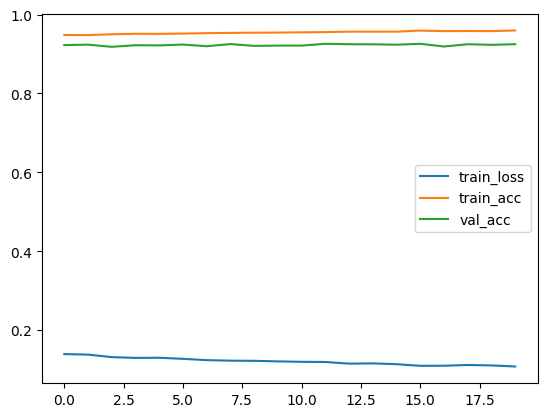

In [33]:
df_history.drop('epoch', axis=1).plot()